# Training IELTS Grammar Correction Model
---
***Last Run 7 Jun 2023 4:52 PM***

This notebook are used to fine tuning IELTS Grammar Correction Model. This model are build with [Transformers T5 Model](https://huggingface.co/docs/transformers/model_doc/t5) and [Happy Transformer Package](https://www.vennify.ai/about/). We will use [t5-base](https://huggingface.co/t5-base) for base model to fine tuning grammar correction.

To fine tuning this model, we use 2 dataset [JFLEG (JHU FLuency-Extended GUG)](https://huggingface.co/datasets/jfleg) Dataset and [C4_200M](https://github.com/google-research-datasets/C4_200M-synthetic-dataset-for-grammatical-error-correction) Dataset.

In this notebook there are several process to fine tuning model.

1.   Preprocessing.
2.   Fine tuning.
3.   Evaluate and predict.
4.   Save model.
5.   Load model.

To fine tuning model, there are several library to use in this process. Required library:

1.   OS.
2.   GIT-LFS.
3.   Happy Transformer.
4.   Hugging Face Hub.
5.   Datasets.
6.   Pandas.
7.   Scikit-Learn.
8.   CSV.
9.   Dotenv.
10.  Datetime.
11.  Time.
12.  Matplotlib.



This notebook are save in [Colab](https://colab.research.google.com/drive/19m_Texmbd61KbkC2xdQgnEaD74SbTmoq?usp=sharing) or [Github](https://github.com/IELTSSpeakingApplication/MachineLearning/tree/main/Training/Grammar). The models result are save in [Hugging Face Hub](https://huggingface.co/hafidikhsan) 

***Fine tuning process required GPU Accelerator***

---
For comparison of model results, we carry out the training process with various combination of datasets but still use the same model architecture. We did some fine tuning process because we want to get maximum results for the grammar correction model.

In this experiment, we use a [C4_200M](https://github.com/google-research-datasets/C4_200M-synthetic-dataset-for-grammatical-error-correction) 125k word Dataset

In [1]:
#@title Accelerate PyTorch
%%capture
!pip install --upgrade accelerate

‼️ ***Restart runtime***

In [1]:
#@title Install .env
%%capture
!pip install python-dotenv

❗️ ***Load .env file***

In [35]:
# Define global variable
import os
from dotenv import load_dotenv

load_dotenv()

DRIVE_DATASET_PATH = "/content/drive/MyDrive/Final Project/Machine Learning/Grammar/Dataset/"

COLAB_BASE_PATH = "/content/"
DRIVE_TARGET_PATH = '''/content/drive/MyDrive/"Final Project"/"Machine Learning"/Grammar/"Fine Tuning"/C4_200M'''

TRAIN_CSV = "Train.csv"
EVAL_CSV = "Eval.csv"

PNG = ".png"
MODEL_EVALUATION = '"Model Evaluation"'
BOXPLOT = '"Boxplot Dataset"'
TRAINING_TIME = '"Training Time"'
MODEL_EVALUATION_PNG = "Model Evaluation.png"
TRAINING_TIME_PNG = "Training Time.png"

REPO_NAME = "IELTS-GEC-T5-C4_200M-125k"
REPO_LINK = "https://huggingface.co/hafidikhsan/" + REPO_NAME

EMAIL = "harifin315@gmail.com"
USERNAME = "hafidikhsan"

COMMIT = '''"Initial commit for IELTS GEC T5 Model with C4_200M 125k word Dataset"'''

TOKEN = os.getenv("TOKEN")
HUGGING_FACE_HUB = "https://" + USERNAME + ":" + TOKEN + "@huggingface.co/" + USERNAME + "/" + REPO_NAME

## Preprocessing 🆗

### Install and import library ✅

In [3]:
#@title Install GIT-LFS
%%capture
!sudo apt-get install git-lfs

In [4]:
#@title Install library Happy Transformer, Hugging Face Hub and Datasets
%%capture
!pip install happytransformer
!pip install huggingface_hub
!pip install datasets

In [5]:
# Import library
import csv
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_dataset, load_from_disk
from happytransformer import HappyTextToText, TTTrainArgs, TTSettings

In [6]:
# Cuda Alocation
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

In [7]:
# Make pandas dataframe big
pd.set_option("display.max_colwidth", None)

### Import base model ✅

In [8]:
# Import base model T5
happy_t5 = HappyTextToText("T5", "t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### Import datasets ✅

#### Drive 🟠

In [9]:
# Drive access
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### C4_200M 15k 🔵

In [ ]:
# Read dataset
df_c4_15k = pd.read_csv(DRIVE_DATASET_PATH + "c4_200m_15k.csv")
df_c4_15k.head()

##### C4_200M 100k 🔵

In [ ]:
# Read dataset
df_c4_100k = pd.read_csv(DRIVE_DATASET_PATH + "c4_200m_100k.csv")
df_c4_100k.head()

##### C4_200M All 🟠

In [ ]:
# Load local dataset
local_hugging_face = load_from_disk(DRIVE_DATASET_PATH + "/c4_200m")
local_hugging_face

###### All 🔵

In [ ]:
# Datasets to pandas
df_c4_all = local_hugging_face["train"].to_pandas()
df_c4_all.head()

###### Cut 🔵

In [ ]:
# Datasets to pandas
df_c4_all_cut = local_hugging_face["train"].to_pandas()
df_c4_all_cut.head()

In [ ]:
# Define sample
sample_data = 1000000

In [ ]:
# Get sample dataset
df_c4_cut = df_c4_all_cut.sample(n=sample_data)
df_c4_cut.head()

#### Hugging Face 🟠

##### C4_200M 125k 🔵

In [10]:
# Load dataset
dataset_c4_125k = load_dataset("leslyarun/c4_200m_gec_train100k_test25k")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/leslyarun___csv/leslyarun--c4_200m_gec_train100k_test25k-8d12761f53d68956/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
# Datasets train to pandas
df_train_c4_125k = dataset_c4_125k["train"].to_pandas()
df_train_c4_125k.head()

,input,output
0,"Bitcoin is for $7,094 this morning, which CoinDesk says.","Bitcoin goes for $7,094 this morning, according to CoinDesk."
1,The effect of widespread dud targets two face up attack position monsters on the field.,"1. The effect of ""widespread dud"" targets two face up attack position monsters on the field."
2,"tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).","Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law."
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
4,this is is the latest Maintenance release of Samba 3.6,This is is the latest maintenance release of Samba 3.6.


In [13]:
# Datasets test to pandas
df_test_c4_125k = dataset_c4_125k["test"].to_pandas()
df_test_c4_125k.head()

,input,output
0,Organizational mission of Kiss The Ground is inspire global participation in the restoration of our soil precious goods.,The organizational mission of Kiss the Ground is to inspire global participation in the restoration of our precious soils.
1,"Tap The Thumbnail Bellow to See Related Gallery of Elegant Window Treatments Elegant Window Treatment ideas design For Elegant Window Treatments decorator ""","Tap The Thumbnail Bellow to See Related Gallery of ""Elegant Window Treatments Elegant Window Treatment Ideas Design For Elegant Window Treatments Decor"""
2,"when I relax that’s when I shake or jolt to me, like the more I relax the more I do if I focus my mind on anything it does’t happened much.","if I relax that’s when I shake or jolt, like the more I relax the more I do if I focus my mind on something it don’t happen much."
3,"Our neighbor Jay-dub (nickname courtesy of me since he remarked last week that all my kids have numerous nickname and only ever call him's Jake) he can claim ownership of our flock since the kids gives him a chick of them, Patty (aka Kevin).","Our neighbor Jay-dub (nickname courtesy me since he remarked last week that all my kids have numerous nicknames and we only ever call him Jake). He can claim ownership of our flock since the kids gave him a chick of his own, Patty (aka Kevin)."
4,"Kummrow Automotive is now a Official Distributor Dinan offers a line of high performance products, upgrades and services to enhance your BMW or MINI.","Kummrow Automotive is now an official Dinan Distributor offering a line of high performance products, upgrades and services to enhance your BMW or MINI."


In [14]:
# Merging dataset
df_c4_125k = pd.concat([df_train_c4_125k, df_test_c4_125k])
df_c4_125k.head()

,input,output
0,"Bitcoin is for $7,094 this morning, which CoinDesk says.","Bitcoin goes for $7,094 this morning, according to CoinDesk."
1,The effect of widespread dud targets two face up attack position monsters on the field.,"1. The effect of ""widespread dud"" targets two face up attack position monsters on the field."
2,"tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).","Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law."
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.
4,this is is the latest Maintenance release of Samba 3.6,This is is the latest maintenance release of Samba 3.6.


##### JFLEG 🔵

In [ ]:
# Load dataset
jfleg_train_dataset = load_dataset("jfleg", split="validation[:]")
jfleg_eval_dataset = load_dataset("jfleg", split="test[:]")

In [ ]:
# Define function to parsing to dataframe
def parsing_to_dataframe(dataset):
    input = []
    target = []

    for case in dataset:
        input_text = case["sentence"]

        for correction in case["corrections"]:
            if input_text and correction:

                input.append(input_text)
                target.append(correction)

    df = pd.DataFrame(list(zip(input, target)), columns=["input", "output"])

    return df

In [ ]:
# Parsing dataset train
df_train_jfleg = parsing_to_dataframe(jfleg_train_dataset)
df_train_jfleg.head()

In [ ]:
# Parsing dataset test
df_test_jfleg = parsing_to_dataframe(jfleg_eval_dataset)
df_test_jfleg.head()

In [ ]:
# Merging dataset
df_jfleg = pd.concat([df_train_jfleg, df_test_jfleg])
df_jfleg.head()

### Merging datasets (Optional) ⁉️

In [ ]:
# Merging dataset
df_merge = pd.concat([df_c4_100k, df_jfleg])
df_merge.head()

### Select dataset ✅

#### C4_200M 🟠

In [ ]:
# Select data for training from C4_200M 15k
df_training = df_c4_15k

In [ ]:
# Select data for training from C4_200M 100k
df_training = df_c4_100k

In [15]:
# Select data for training from C4_200M 125k
df_training = df_c4_125k

In [ ]:
# Select data for training from C4_200M cut
df_training = df_c4_cut

In [ ]:
# Select data for training from C4_200M all
df_training = df_c4_all

#### JFLEG 🟠

In [ ]:
# Select data for training from JFLEG
df_training = df_jfleg

#### Merge 🟠

In [ ]:
# Select data for training from merging
df_training = df_merge

### Word count ✅

In [16]:
# Define function to count word
def word_count_func(text):
    return len(text.split())

#### Input 🟢

In [17]:
# Mapping to dataset
df_training["lenght_input"]= df_training["input"].apply(lambda x:word_count_func(x))
df_training.head()

,input,output,lenght_input
0,"Bitcoin is for $7,094 this morning, which CoinDesk says.","Bitcoin goes for $7,094 this morning, according to CoinDesk.",9
1,The effect of widespread dud targets two face up attack position monsters on the field.,"1. The effect of ""widespread dud"" targets two face up attack position monsters on the field.",15
2,"tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).","Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law.",59
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.,9
4,this is is the latest Maintenance release of Samba 3.6,This is is the latest maintenance release of Samba 3.6.,10


In [18]:
# Display longest
df_training[df_training["lenght_input"]==df_training["lenght_input"].max()]

,input,output,lenght_input
39832,"Spot-billed Pelican, Great Cormorant, Little Cormorant, Oriental Darter, Greater Flamingo, Herons (Indian Pond & Grey), Egrets (Cattle, Little, Intermediate, Great & Western Reef), Painted Stork, Asian Openbill, Lesser Adjutant, Little Grebe, Lesser Whistling-duck, Eurasian Wigeon, Garganey, Common Buzzard, Brahminy Kite, Black Kite, Western Head fiss Kestrel, Grey Francolin, Indian Peafowl, White-breasted shallow Indian disastrous u, Grey Francolin, Indian Peafowl, White-breasted Waterhen, Crab-plover en, White-breasted Waterhen, Crab-plover TurRollwings Waterhen, Crab-plover, Black-winged Stilt, Red-va, Black-winged Stilt, Red-wattled Lapwing, Common Ringed blown-wattled Lapwing, Common Ringed Plover ace, White-breasted Waterhen, Crab-plover, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover lak, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover, Kentish Plover, Common Redshank ve, Grey Francolin, Indian Peafowl, White-breasted Waterhen, Crab-plover, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover, Kentish Plover, Common Redshank, Common Sandpiper, Ruddy Turnstone, HimaKestrel, Grey Francolin, Indian Peafowl, White-breasted Waterhen, Crab-plover, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover, Kentish Plover, Common Redshank, Common Sandpiper, Ruddy Turnstone, 'hed Heuglin’s Gull, Great Black-headed Gull, Common Black-headed Gull unb, Kentish Plover, Common Redshank, Common Sandpiper, Ruddy Turnstone, Heuglin’s Gull, Great Black-headed Gull, Common Black-headed Gull, Caspian Tern, Common Tern, Little Tern, Spotted spikeguarded Black-headed Gull, Common Black-headed Gull, Caspian Tern, Common Tern, Little Tern, Spotted Dove, Eurasian Collard Dove, Rose-ringed Parakeet, Large-billed Crow, White-throated Kingfisher, Crab-plover, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover, Kentish Plover, Common Redshank, Common Sandpiper, Ruddy Turnstone, Heuglin’s Gull, Great Black-headed Gull, Common Black-headed Gull, Caspian Tern, Common Tern, Little Tern, Spotted Dove, Eurasian Collard Dove, Rose-ringed Parakeet, Large-billed Crow, White-throated Kingfisher, Blue Ende, Kentish Plover, Common Redshank, Common Sandpiper, Ruddy Turnstone, Heuglin’s Gull, Great Black-headed Gull, Common Black-headed Gull, Caspian Tern, Common Tern, Little Tern, Spotted Dove, Eurasian Collard Dove, Rose-ringed Parakeet, Large-billed Crow, White-throated Kingfisher, Blue-tailed Bee-eater, Indian Roller, Asian Palm Swift, Red Ree, Common Sandpiper, Ruddy Turnstone, Heuglin’s Gull, Great Black-headed Gull, Common Black-headed Gull, Caspian Tern, Common Tern, Little Tern, Spotted Dove, Eurasian Collard Dove, Rose-ringed Parakeet, Large-billed Crow, White-throated Kingfisher, Blue-tailed Bee-eater, Indian Roller, Asian Palm Swift, Red-vented Bulbul, Oriental Magpie-Robin, Black, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover, Kentish Plover, Common Redshank, Common Sandpiper, Ruddy Turnstone, Heuglin’s Gull, Great Black-headed Gull, Common Black-headed Gull, Caspian Tern, Common Tern, Little Tern, Spotted Dove, Eurasian Collard Dove, Rose-ringed Parakeet, Large-billed Crow, White-throated Kingfisher, Blue-tailed Bee-eater, Indian Roller, Asian Palm Swift, Red-vented Bulbul, Oriental Magpie-Robin, Black, Indian Roller, Asian Palm Swift, Red-vented Bulbul, Oriental Magpie-Robin, Black-backed Robin ed, Common Myna.","Spot-billed Pelican, Great Cormorant, Little Cormorant, Oriental Darter, Greater Flamingo, Herons (Indian Pond & Grey), Egrets (Cattle, Little, Intermediate, Great & Western Reef), Painted Stork, Asian Openbill, Lesser Adjutant, Little Grebe, Lesser Whistling-duck, Eurasian Wigeon, Garganey, Common Buzzard, Brahminy Kite, Black Kite, Western Marsh Harrier, White-bellied Fish Eagle, Common, Kestrel, Grey Francolin, Indian Peafowl, White-breasted Waterhen, Crab-plover, Black-winged Stilt, Red-wattled Lapwing, Common Ringed Plover, Kentish 

#### Output 🟢

In [19]:
# Mapping to dataset
df_training["lenght_output"]= df_training["output"].apply(lambda x:word_count_func(x))
df_training.head()

,input,output,lenght_input,lenght_output
0,"Bitcoin is for $7,094 this morning, which CoinDesk says.","Bitcoin goes for $7,094 this morning, according to CoinDesk.",9,9
1,The effect of widespread dud targets two face up attack position monsters on the field.,"1. The effect of ""widespread dud"" targets two face up attack position monsters on the field.",15,16
2,"tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).","Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law.",59,63
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.,9,8
4,this is is the latest Maintenance release of Samba 3.6,This is is the latest maintenance release of Samba 3.6.,10,10


In [20]:
# Display longest
df_training[df_training["lenght_output"]==df_training["lenght_output"].max()]

,input,output,lenght_input,lenght_output
46860,"This is one of the most useful Alveston road maps you can get, and using all navigation features you will be able to find churches in Alveston village centre, schools in Alveston village centre, pubs in Alveston village centre, hotels in Alveston village centre, restaurants in Alveston village centre, attaractions in Alveston village centre, museums in Alveston village centre, clubs in Alveston village centre, a bus stops in Alveston village centre, cafes in Alveston village centre, parks in Alveston village centre, in Alveston village centre, gyms in Alveston village centre, shops in Alveston village centre, guest houses in Alveston central village centre, businesses in Alveston village centre, places to visit in Alveston village centre, shopping centres in Alveston village centre, sports centres in Alveston village centre, gyms in Alveston village centre, shops in Alveston village centre, guest houses in Alveston village centre, B&B's in Alveston village centre, leisure centres in Alveston village places to visit in Alveston village centre, shopping centres in Alveston village centre, sports centres in Alveston village centre, gyms in Alveston village centre, shops in Alveston village centre, guest houses in Alveston village centre, B&B's in Alveston village centre, leisure centres in Alveston village centre, banks in Alveston village centre, health village centre, B&B's in Alveston village centre, leisure centres in Alveston village centre, banks in Alveston village centre, health facilities in Alveston village centre.","This is one of the most useful Alveston road maps you can get, and by using all the navigation features you will be able to find churches in Alveston village centre, schools in Alveston village centre, pubs in Alveston village centre, hotels in Alveston village centre, restaurants in Alveston village centre, attractions in Alveston village centre, museums in Alveston village centre, clubs in Alveston village centre, bus stops in Alveston village centre, cafes in Alveston village centre, parks in Alveston village centre, take-aways in Alveston village centre, businesses in Alveston village centre, places to visit in Alveston village centre, shopping centres in Alveston village centre, sports centres in Alveston village centre, gyms in Alveston village centre, shops in Alveston village centre, guest houses in Alveston village centre, B&B's in Alveston village centre, leisure centres in Alveston village centre, banks in Alveston village centre, health facilities in Alveston village centre.",228,149


### Check dataset ✅

In [21]:
# Display final dataset
df_training.head()

,input,output,lenght_input,lenght_output
0,"Bitcoin is for $7,094 this morning, which CoinDesk says.","Bitcoin goes for $7,094 this morning, according to CoinDesk.",9,9
1,The effect of widespread dud targets two face up attack position monsters on the field.,"1. The effect of ""widespread dud"" targets two face up attack position monsters on the field.",15,16
2,"tax on sales of stores for non residents are set at 21% for 2014 and 20% in 2015 payable on sales tentatively earned from the difference of the property value some time of purchase (price differences according to working time) and theyear to which sale couples (sales costs), based on the approved annual on the base approved by law).","Capital Gains tax on the sale of properties for non-residents is set at 21% for 2014 and 20% in 2015 payable on profits earned on the difference of the property value between the year of purchase (purchase price plus costs) and the year of sale (sales price minus costs), based on the approved annual percentage increase on the base value approved by law.",59,63
3,Much many brands and sellers still in the market.,Many brands and sellers still in the market.,9,8
4,this is is the latest Maintenance release of Samba 3.6,This is is the latest maintenance release of Samba 3.6.,10,10


In [22]:
# Display final dataset
df_training.tail()

,input,output,lenght_input,lenght_output
24995,"And if you grab it a day, you’ll get limitted time discount!","And if you grab it today, you’ll get a limited time discount!",12,12
24996,Anyone know the name of the buff,Anyone know the name of the buff?,7,7
24997,A. AnS IBM TS3500 storage frame must be upgraded to HD2 before it can be modified again.,A. An IBM TS3500 storage frame must be upgraded to HD2 before it can be redeployed.,17,16
24998,I teamed up with a few of my blogger friends for National Sleep Week and we’re answering some sleep related topics!,I teamed up with a few of my blogger friends for National Sleep Week and we’re answering some sleep related questions!,21,21
24999,"Salazar has been acknowledge that her campaign was somewhat off-guard caught by the intense media scrutiny, and that she and her small staff ""weren't on the same page"" about some aspects of her background.","Salazar has acknowledged that her campaign was somewhat caught off-guard by the intense media scrutiny, and that she and her small staff ""weren't on the same page"" about some aspects of her background.",34,33


In [23]:
# Display dataframe info
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   input          125000 non-null  object
 1   output         125000 non-null  object
 2   lenght_input   125000 non-null  int64 
 3   lenght_output  125000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


In [24]:
# Check isnull in training dataset
df_training.isnull().any()

input            False
output           False
lenght_input     False
lenght_output    False
dtype: bool

In [25]:
# Define function for display boxplot
def box_plot(df, title):
    plt_title = title
    input = df["lenght_input"].values
    output = df["lenght_output"].values
    all = [input, output]

    fig = plt.figure(figsize= (12, 5))
    ax = fig.add_subplot(111)

    bp = ax.boxplot(all, labels=["Input", "Output"]) 

    plt.xlabel("Box Plot", size=15)
    plt.ylabel("Jumlah", size=15)
    plt.xticks(size=12)
    plt.title(plt_title, size=18)

    plt.show()
    fig.savefig(f"{title}.png", dpi=300.0)

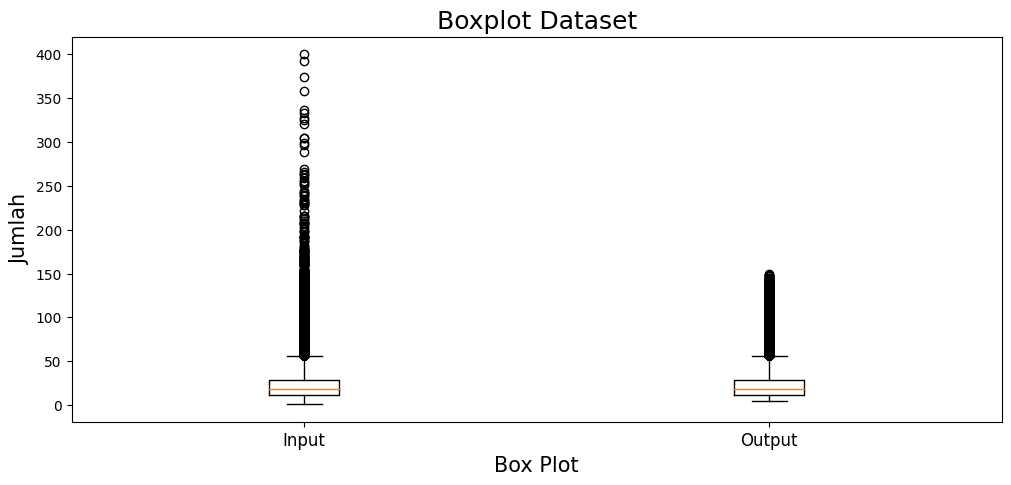

In [26]:
# Display boxplot
box_plot(df_training, "Boxplot Dataset")

### Split dataset ✅

In [27]:
# Split dataset
df_train, df_test = train_test_split(df_training, test_size=0.2)

In [28]:
# Data check
print("Total training data     ", len(df_train.index), " line.")
print("Total test data         ", len(df_test.index), " line.")

Total training data      100000  line.
Total test data          25000  line.


### Generate to csv ✅

In [29]:
# Define function to generate csv
def generate_csv(csv_path, dataset):
    with open(csv_path, "w", newline="") as csvfile:
        writter = csv.writer(csvfile)
        writter.writerow(["input", "target"])

        for case in dataset:
            input_text = "grammar: " + case["input"]
            correction = case["output"]
            
            writter.writerow([input_text, correction])

In [30]:
# Pandas to dataset
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)

In [31]:
# Generate csv dataset
generate_csv(TRAIN_CSV, dataset_train)
generate_csv(EVAL_CSV, dataset_test)

### Save to Drive ✅

In [32]:
# Save data
!cp -r {COLAB_BASE_PATH + TRAIN_CSV} {DRIVE_TARGET_PATH}
!cp -r {COLAB_BASE_PATH + EVAL_CSV} {DRIVE_TARGET_PATH}
!cp -r {COLAB_BASE_PATH + BOXPLOT + PNG} {DRIVE_TARGET_PATH}

## Fine Tuning 🆗

### Evaluate base model ✅

In [33]:
# Evalute base model before training
before_result = happy_t5.eval(EVAL_CSV)
loss_before_fine_tuning = before_result.loss

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-ff804a863c9f790b/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3606: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [34]:
# Display loss
print("Before loss:", loss_before_fine_tuning)

Before loss: 1.9065099954605103


### Training model ✅

In [36]:
# Define timer function
def timer(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

In [41]:
# Training model
args = TTTrainArgs(batch_size=1, num_train_epochs=1)

print("Start fine tuning...")
date_time_init = datetime.datetime.now().strftime("%Y-%m-%d at %H:%M:%S UTC")
print(date_time_init+"\n")

time_training_init = time.time()

happy_t5.train(TRAIN_CSV, args=args)

time_training_end = time.time()
time_training = time_training_init - time_training_end

print("\nEnd fine tuning...")
date_time_end = datetime.datetime.now().strftime("%Y-%m-%d at %H:%M:%S UTC")
print(date_time_end+"\n")

print("Fine tuning time:")
timer(time_training_init, time_training_end)

Start fine tuning...
2023-06-07 at 06:12:14 UTC



  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Step,Training Loss
500,0.587600
1000,0.667300
1500,0.638600
2000,0.686900
2500,0.603600
3000,0.573700
3500,0.627800
4000,0.652300
4500,0.679100
5000,0.716300



End fine tuning...
2023-06-07 at 09:33:16 UTC

Fine tuning time:
03:21:02.58


## Evaluate and predict 🆗

### Evaluate ✅

In [42]:
# Evaluate model after fine tuning
after_loss = happy_t5.eval(EVAL_CSV)
loss_after_fine_tuning = after_loss.loss

  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [43]:
# Display loss
print("After loss:", loss_after_fine_tuning)

After loss: 0.5838221907615662


### Visualize ✅

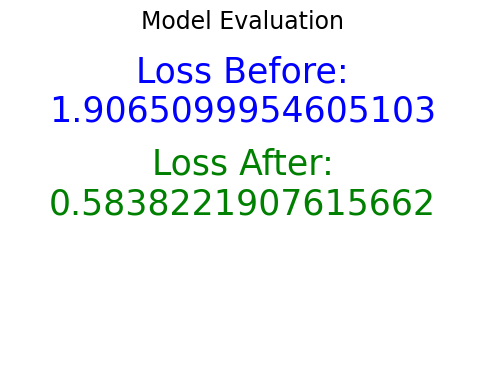

In [44]:
# Display evaluation
fig, ax = plt.subplots(figsize=(6, 4))

ax.text(0.5, 1, f"Loss Before:\n{loss_before_fine_tuning}",
        verticalalignment="top", horizontalalignment="center",
        transform=ax.transAxes,
        color="blue", fontsize=25)

ax.text(0.5, 0.7, f"Loss After:\n{loss_after_fine_tuning}",
        verticalalignment="top", horizontalalignment="center",
        transform=ax.transAxes,
        color="green", fontsize=25)

plt.title(label="Model Evaluation", fontsize=17, pad=19)
plt.axis("off")

# Save data in image
plt.savefig(MODEL_EVALUATION_PNG, dpi=300.0, transparent=True)

In [45]:
# Define timer
def display_timer(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return int(hours), int(minutes), seconds

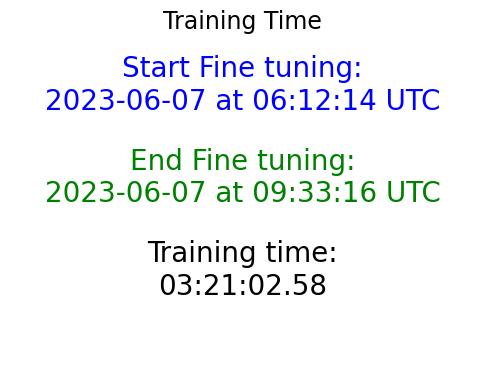

In [46]:
# Display training time
fig, ax = plt.subplots(figsize=(6, 4))

hours_train, minutes_train, seconds_train = display_timer(time_training_init, time_training_end)

ax.text(0.5, 1, f"Start Fine tuning:\n{date_time_init}",
        verticalalignment="top", horizontalalignment="center",
        transform=ax.transAxes,
        color="blue", fontsize=20)
ax.text(0.5, 0.7, f"End Fine tuning:\n{date_time_end}",
        verticalalignment="top", horizontalalignment="center",
        transform=ax.transAxes,
        color="green", fontsize=20)
ax.text(0.5, 0.4, "Training time:\n{:0>2}:{:0>2}:{:05.2f}".format(int(hours_train), int(minutes_train), seconds_train),
        verticalalignment="top", horizontalalignment="center",
        transform=ax.transAxes,
        color="black", fontsize=20)

plt.title(label="Training Time", fontsize=17, pad=19)
plt.axis("off")

# Save data in image
plt.savefig(TRAINING_TIME_PNG, dpi=300.0, transparent=True)

### Predict ✅

In [47]:
# Input text
text = "For mee, I think an job such as cameraman need a lot of physical work because what I know about camera is that it really heavy"

In [48]:
# Predict
beam_settings =  TTSettings(num_beams=8, min_length=1, max_length=1024)
text_generate = "grammar: " + text

result = happy_t5.generate_text(text_generate, args=beam_settings)

print(result.text)

For me, I think a job such as cameraman needs a lot of physical work because what I know about camera is that it really heavy.


### Save to Drive ✅

In [49]:
# Save training process
!cp -r {COLAB_BASE_PATH + MODEL_EVALUATION + PNG} {DRIVE_TARGET_PATH}
!cp -r {COLAB_BASE_PATH + TRAINING_TIME + PNG} {DRIVE_TARGET_PATH}

## Save model 🆗

In [50]:
# Login hugging face
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid (permission: write).
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' cr

In [51]:
# Create new repo
!huggingface-cli repo create {REPO_NAME}

git version 2.25.1
git-lfs/2.9.2 (GitHub; linux amd64; go 1.13.5)

You are about to create hafidikhsan/IELTS-GEC-T5-C4_200M-125k
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/hafidikhsan/IELTS-GEC-T5-C4_200M-125k

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/hafidikhsan/IELTS-GEC-T5-C4_200M-125k



In [52]:
# Clone repo
!git clone {REPO_LINK}

Cloning into 'IELTS-GEC-T5-C4_200M-125k'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), 413 bytes | 413.00 KiB/s, done.


In [53]:
# Git LFS init
%cd content
%cd {REPO_NAME}

!git lfs install

%cd ..

[Errno 2] No such file or directory: 'content'
/content
/content/IELTS-GEC-T5-C4_200M-125k
Updated git hooks.
Git LFS initialized.
/content


In [54]:
# Save model
happy_t5.save(REPO_NAME + "/")

In [55]:
# Go to repo
%cd {REPO_NAME}
!git status

/content/IELTS-GEC-T5-C4_200M-125k
On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	config.json
	generation_config.json
	pytorch_model.bin
	special_tokens_map.json
	spiece.model
	tokenizer.json
	tokenizer_config.json

nothing added to commit but untracked files present (use "git add" to track)


In [56]:
# Stage git
!git add .
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   config.json
	new file:   generation_config.json
	new file:   pytorch_model.bin
	new file:   special_tokens_map.json
	new file:   spiece.model
	new file:   tokenizer.json
	new file:   tokenizer_config.json



In [57]:
# Config git
!git config --global user.email {EMAIL}
!git config --global user.name {USERNAME}

In [58]:
# Commit git
!git commit -m {COMMIT}

[main 1f9aa15] Initial commit for IELTS GEC T5 Model with C4_200M 125k word Dataset
 7 files changed, 129707 insertions(+)
 create mode 100644 config.json
 create mode 100644 generation_config.json
 create mode 100644 pytorch_model.bin
 create mode 100644 special_tokens_map.json
 create mode 100644 spiece.model
 create mode 100644 tokenizer.json
 create mode 100644 tokenizer_config.json


In [59]:
# Push to Hugging Face
!git push {HUGGING_FACE_HUB}

Uploading LFS objects: 100% (2/2), 892 MB | 33 MB/s, done.
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 4 threads
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 604.90 KiB | 6.37 MiB/s, done.
Total 9 (delta 1), reused 0 (delta 0)
To https://huggingface.co/hafidikhsan/IELTS-GEC-T5-C4_200M-125k
   8062065..1f9aa15  main -> main


## Load model 🆗

In [60]:
#@title Install library
%%capture
!pip install errant
!pip install happytransformer
!pip install -U openai-whisper

In [61]:
#@title Download spacy
%%capture
!python -m spacy download en

In [62]:
# Import library
from happytransformer import HappyTextToText
from happytransformer import TTSettings
import whisper
import errant
import re

In [63]:
# Define audio wav test
audio_wav = "/content/drive/MyDrive/Final Project/Machine Learning/Fluency/Test audio/Citeureup 2.wav"

In [64]:
# Define asr function
def speech_to_text(model_base, audio_path):
    result = model_base.transcribe(audio_path)
    return result["text"]

In [65]:
# Define grammar function
def grammar_test(model_base, text):
    beam_settings =  TTSettings(num_beams=8, min_length=1, max_length=1024)
    text_generate = "grammar: " + text
    result = model_base.generate_text(text_generate, args=beam_settings)
    return result.text

In [66]:
# Define error calculation function
def error_calculation(annotator, original_text = "", correction_text = ""):
    orig = annotator.parse(original_text)
    cor = annotator.parse(correction_text)
    edits = annotator.annotate(orig, cor)

    correct_text_len = len(re.findall(r"\w+", correction_text))
    error_len = len(edits)

    percent = (1 - (error_len/correct_text_len)) * 100

    return percent

In [67]:
# Define level function
def to_level(percent = 0):
    if percent >= 90 and percent <= 100:
        return 9
    elif percent >= 80 and percent < 90:
        return 8
    elif percent >= 70 and percent < 80:
        return 7
    elif percent >= 60 and percent < 70:
        return 6
    elif percent >= 50 and percent < 60:
        return 5
    elif percent >= 40 and percent < 50:
        return 4
    elif percent >= 30 and percent < 40:
        return 3
    elif percent >= 20 and percent < 30:
        return 2
    elif percent >= 0 and percent < 20:
        return 1
    else:
        return 0

In [68]:
# Define IELTS Grammar function
def grammar(model_gec, model_whisper, wav):
    annotator = errant.load("en")

    asr = speech_to_text(model_whisper, wav)

    correct = grammar_test(model_gec, asr)

    error_percent = error_calculation(annotator, asr, correct)

    level = to_level(error_percent)

    return level

In [69]:
# Initialize ASR
model_whisper = whisper.load_model("medium.en")

100%|█████████████████████████████████████| 1.42G/1.42G [00:20<00:00, 74.0MiB/s]


In [70]:
# Load model
hafid_happy_t5 = HappyTextToText("T5", "hafidikhsan/" + REPO_NAME)

In [71]:
# Band predict
predict_band = grammar(hafid_happy_t5, model_whisper, audio_wav)
print("Grammar band is", predict_band)

Grammar band is 9
